## Julia Interfacing with R and Python

In [1]:
using PyCall
using RCall
using DecisionTree
using DataFrames
using ScikitLearn
using VegaDatasets
ENV["COLUMNS"]=1000; # for dataframe column size
ENV["LINES"]=10;
warning = pyimport("warnings")
warning.filterwarnings("ignore")

### R"" vs py"" String Macro

- R"" executes R commands inside the string and returns an R object 
- py"" executes Python commands with implicit conversion of python objects into Julia data type.

In [2]:
py"1+1" # returns julia numeric value by implicit conversion

2

In [3]:
R"result=1+1" # returns an RObject

RObject{RealSxp}
[1] 2


In [4]:
@rget result # use @rget macro to copy value from R to Julia

2.0

In [5]:
R"1+1" |> rcopy # or use rcopy to directoy convert R object into Julia data type 

2.0

### Defining a function in Python

In [6]:
py"""

import numpy as np

def mysin(x):
   return np.sin(x)
"""

In [7]:
py"mysin(10)" # calling python function

-0.5440211108893699

In [8]:
py"np.sin(10)"  # calling directly numpy sin function

-0.5440211108893699

In [9]:
pyimport("numpy").sin(10) # import numpy and call sin directly

-0.5440211108893699

### Defining a function in R

In [10]:
R"""
mysin <- function(x) {
   sin(x)
}
""";

In [11]:
R"mysin(10)" |> rcopy   # R"" returns an object which rcopy converts to Julia data

-0.5440211108893699

## Copying from-to R/Julia

In [12]:
iris = R"iris" |> rcopy # copy iris dataset from R to Julia
iris |> (x->first(x,5))

,Sepal_Length,Sepal_Width,Petal_Length,Petal_Width,Species
,Float64,Float64,Float64,Float64,Cat…
1,5.1,3.5,1.4,0.2,setosa
2,4.9,3.0,1.4,0.2,setosa
3,4.7,3.2,1.3,0.2,setosa
4,4.6,3.1,1.5,0.2,setosa
5,5.0,3.6,1.4,0.2,setosa


In [13]:
df = DataFrame(a=rand(5),b=rand(5)) # create dataframe

,a,b
,Float64,Float64
1,0.909073,0.737494
2,0.508891,0.866433
3,0.737602,0.223443
4,0.0727541,0.628861
5,0.849127,0.426997


In [14]:
@rput df # copy df to R

,a,b
,Float64,Float64
1,0.909073,0.737494
2,0.508891,0.866433
3,0.737602,0.223443
4,0.0727541,0.628861
5,0.849127,0.426997


In [15]:
R"df" # check if R got df

RObject{VecSxp}
          a         b
1 0.9090725 0.7374944
2 0.5088908 0.8664333
3 0.7376019 0.2234426
4 0.0727541 0.6288608
5 0.8491275 0.4269966


### Plotting with R and Python

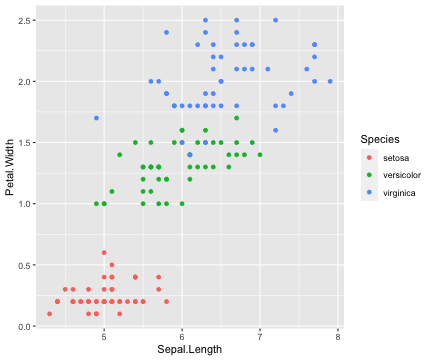

RObject{VecSxp}


In [16]:
R"""
library(ggplot2)

ggplot(iris,aes(x=Sepal.Length,y=Petal.Width))+geom_point(aes(color=Species))
"""

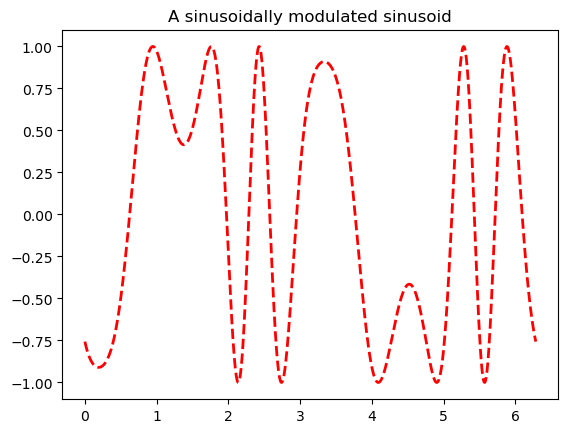

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /Users/ppalmes/.julia/packages/PyCall/L0fLP/src/numpy.jl:67


PyObject Text(0.5, 1.0, 'A sinusoidally modulated sinusoid')

In [17]:
using PyPlot
x = range(0; stop=2*pi, length=1000); y = sin.(3 * x + 4 * cos.(2 * x));
plot(x, y, color="red", linewidth=2.0, linestyle="--")
title("A sinusoidally modulated sinusoid")

###   Scikitlearn classifiers using Julia bindings of Python (PyCall.jl)

Let's load the `car` dataset for this example.

In [18]:
using VegaDatasets
cars=dataset("cars") |> DataFrame;
first(cars,5)

,Name,Miles_per_Gallon,Cylinders,Displacement,Horsepower,Weight_in_lbs,Acceleration,Year,Origin
,String,Float64?,Int64,Float64,Int64?,Int64,Float64,String,String
1,chevrolet chevelle malibu,18.0,8,307.0,130,3504,12.0,1970-01-01,USA
2,buick skylark 320,15.0,8,350.0,165,3693,11.5,1970-01-01,USA
3,plymouth satellite,18.0,8,318.0,150,3436,11.0,1970-01-01,USA
4,amc rebel sst,16.0,8,304.0,150,3433,12.0,1970-01-01,USA
5,ford torino,17.0,8,302.0,140,3449,10.5,1970-01-01,USA


In [19]:
@rput cars
cars = R"cars = cars[complete.cases(cars),]" |> rcopy;

In [20]:
using PyCall
LNM = pyimport("sklearn.linear_model");
learner=LNM.LogisticRegression()

x=cars[:,[2,4,5,6,7]] |> Matrix
y=cars[:,:Cylinders] |> Array;

model=learner.fit(x, y)
yhat = model.predict(x)
accuracy = sum(yhat .== y) / length(y)
println("accuracy: $accuracy")

accuracy: 0.951530612244898


In [21]:
R"table($yhat,$y)"

RObject{IntSxp}
   
      3   4   5   6   8
  3   4   0   0   0   0
  4   0 196   3   4   0
  5   0   1   0   1   0
  6   0   2   0  75   5
  8   0   0   0   3  98


In [22]:
learner

PyObject LogisticRegression()

In [23]:
using ScikitLearn.CrossValidation: cross_val_score

KNN = pyimport("sklearn.neighbors")

modelKNN = KNN.KNeighborsClassifier(3)

cross_val_score(modelKNN, x, y; cv=10)  # 5-fold

┌ Warning: The least populated class in y has only 3 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
└ @ ScikitLearn.Skcore /Users/ppalmes/.julia/packages/ScikitLearn/ssekP/src/cross_validation.jl:144


10-element Vector{Float64}:
 0.8095238095238095
 0.9523809523809523
 0.9047619047619048
 ⋮
 0.868421052631579
 0.9459459459459459

In [24]:
using ScikitLearn.GridSearch: GridSearchCV

GS=pyimport("sklearn.model_selection");

lbgfs=LNM.LogisticRegression(multi_class="auto",solver="lbfgs")

PyObject LogisticRegression()

In [25]:
gridsearch = GS.GridSearchCV(lbgfs, Dict(:C => 0.1:0.1:2.0))
res=gridsearch.fit(x, y)
println("Best parameters: $(res.best_params_)")

Best parameters: Dict{Any, Any}("C" => 0.1)


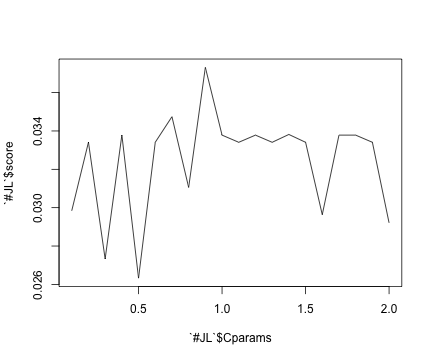

In [26]:
Cparams=convert.(Float64,res.cv_results_["param_C"])
score = res.cv_results_["std_test_score"]
R"plot($Cparams,$score,type='l')";

In [27]:
using PyCall
const ENS=pyimport("sklearn.ensemble")
const LM=pyimport("sklearn.linear_model")
const DA=pyimport("sklearn.discriminant_analysis")
const NN=pyimport("sklearn.neighbors")
const SVM=pyimport("sklearn.svm")
const TREE=pyimport("sklearn.tree")
const ANN=pyimport("sklearn.neural_network")
const GP=pyimport("sklearn.gaussian_process")
const KR=pyimport("sklearn.kernel_ridge")
const NB=pyimport("sklearn.naive_bayes")
const ISO=pyimport("sklearn.isotonic")

PyObject <module 'sklearn.isotonic' from '/Users/ppalmes/.local/lib/python3.9/site-packages/sklearn/isotonic.py'>

In [28]:
learners = Dict(
  "AdaBoostClassifier" => ENS.AdaBoostClassifier,
  "BaggingClassifier" => ENS.BaggingClassifier,
  "ExtraTreesClassifier" => ENS.ExtraTreesClassifier,
  "VotingClassifier" => ENS.VotingClassifier,
  "GradientBoostingClassifier" => ENS.GradientBoostingClassifier,
  "RandomForestClassifier" => ENS.RandomForestClassifier,
  "LDA" => DA.LinearDiscriminantAnalysis,
  "QDA" => DA.QuadraticDiscriminantAnalysis,
  "LogisticRegression" => LM.LogisticRegression,
  "PassiveAggressiveClassifier" => LM.PassiveAggressiveClassifier,
  "RidgeClassifier" => LM.RidgeClassifier,
  "RidgeClassifierCV" => LM.RidgeClassifierCV,
  "SGDClassifier" => LM.SGDClassifier,
  "KNeighborsClassifier" => NN.KNeighborsClassifier,
  "RadiusNeighborsClassifier" => NN.RadiusNeighborsClassifier,
  "NearestCentroid" => NN.NearestCentroid,
  "SVC" => SVM.SVC,
  "LinearSVC" => SVM.LinearSVC,
  "NuSVC" => SVM.NuSVC,
  "MLPClassifier" => ANN.MLPClassifier,
  "GaussianProcessClassifier" => GP.GaussianProcessClassifier,
  "DecisionTreeClassifier" => TREE.DecisionTreeClassifier,
  "GaussianNB" => NB.GaussianNB,
  "MultinomialNB" => NB.MultinomialNB,
  "ComplementNB" => NB.ComplementNB,
  "BernoulliNB" => NB.BernoulliNB
);

In [29]:
function sktrain(learner,x,y)
    model = learner()
    xx = x |> Matrix
    yy = y |> Array
    model.fit(xx,yy)
    return model
end

sktrain (generic function with 1 method)

In [30]:
function skpredict(themodel,x)
    xx = x |> Matrix
    return themodel.predict(xx) |> collect
end

skpredict (generic function with 1 method)

In [31]:
R"""
library(caret)

cars = cars[complete.cases(cars),]
cars$Cylinders = as.factor(cars$Cylinders)

trainIndex <- createDataPartition(cars$Cylinders, p = .8,list=F)

train = cars[trainIndex,]
test = cars[-trainIndex,]
"""

┌ Warning: RCall.jl: Loading required package: lattice
└ @ RCall /Users/ppalmes/.julia/packages/RCall/6kphM/src/io.jl:172


RObject{VecSxp}
                                 Name Miles_per_Gallon Cylinders Displacement
3                  plymouth satellite             18.0         8          318
26       volkswagen 1131 deluxe sedan             26.0         4           97
29                           saab 99e             25.0         4          104
59                        peugeot 304             30.0         4           79
61                toyota corolla 1200             31.0         4           71
64                   plymouth cricket             26.0         4           91
67                  volkswagen type 3             23.0         4           97
70                   chevrolet impala             13.0         8          350
80                   amc matador (sw)             15.0         8          304
83     plymouth satellite custom (sw)             14.0         8          318
87                    renault 12 (sw)             26.0         4           96
91                    dodge colt (sw)           

In [32]:
@rget train test

,Name,Miles_per_Gallon,Cylinders,Displacement,Horsepower,Weight_in_lbs,Acceleration,Year,Origin
,String,Float64,Cat…,Float64,Int64,Int64,Float64,String,String
1,plymouth satellite,18.0,8,318.0,150,3436,11.0,1970-01-01,USA
2,volkswagen 1131 deluxe sedan,26.0,4,97.0,46,1835,20.5,1970-01-01,Europe
3,saab 99e,25.0,4,104.0,95,2375,17.5,1970-01-01,Europe
4,peugeot 304,30.0,4,79.0,70,2074,19.5,1971-01-01,Europe
5,toyota corolla 1200,31.0,4,71.0,65,1773,19.0,1971-01-01,Japan
6,plymouth cricket,26.0,4,91.0,70,1955,20.5,1971-01-01,USA
7,volkswagen type 3,23.0,4,97.0,54,2254,23.5,1972-01-01,Europe
8,chevrolet impala,13.0,8,350.0,165,4274,12.0,1972-01-01,USA
9,amc matador (sw),15.0,8,304.0,150,3892,12.5,1972-01-01,USA


In [33]:
xtrain=train[:,[2,4,5,6,7]] |> Matrix
ytrain=train[:,:Cylinders] |> Array;
xtest=test[:,[2,4,5,6,7]] |> Matrix
ytest=test[:,:Cylinders] |> Array;

### Try ExtraTrees Classifier

In [34]:
modelLR = sktrain(learners["ExtraTreesClassifier"],xtrain,ytrain)
yhat = skpredict(modelLR,xtest);
acc=sum(yhat .== ytest) / length(yhat)

0.9866666666666667

### Try AdaBoost Classifier

In [35]:
modelLR = sktrain(learners["AdaBoostClassifier"],xtrain,ytrain)
res = skpredict(modelLR,xtest);
acc=sum(res .== ytest) / length(ytest)

0.9733333333333334

### Try RandomForest Classifier

In [36]:
modelLR = sktrain(learners["RandomForestClassifier"],xtrain,ytrain)
res = skpredict(modelLR,xtest);
acc=sum(res .== ytest) / length(ytest)

0.9733333333333334

### Let's use R's Caret to predict Cars' Cylinders

In [37]:
using RCall
R"""
library(caret)
library(e1071)
library(randomForest)
library(xgboost)
"""

┌ Warning: RCall.jl: randomForest 4.6-14
│ Type rfNews() to see new features/changes/bug fixes.
│ 
│ Attaching package: ‘randomForest’
│ 
│ The following object is masked from ‘package:ggplot2’:
│ 
│     margin
│ 
└ @ RCall /Users/ppalmes/.julia/packages/RCall/6kphM/src/io.jl:172


RObject{StrSxp}
 [1] "xgboost"      "randomForest" "e1071"        "caret"        "lattice"     
 [6] "ggplot2"      "stats"        "graphics"     "grDevices"    "utils"       
[11] "datasets"     "methods"      "base"        


In [38]:
function crtrain(learner,x::DataFrame,y::Vector)
    xx = x |> DataFrame # DataFrame(x)
    yy = y |> Vector
    model = rcall(:train,xx,yy,method=learner)
    return model
end

crtrain (generic function with 1 method)

In [39]:
function crtpredict(model,x)
    xx = x |> DataFrame
    res = rcall(:predict,model,xx) #in robj
    return rcopy(res) |> collect  # return extracted robj
end

crtpredict (generic function with 1 method)

### Let's try RandForest in R

In [40]:
xtrain=train[:,[2,4,5,6,7]] |> DataFrame
ytrain=train[:,:Cylinders] |> Array;
xtest=test[:,[2,4,5,6,7]] |> DataFrame
ytest=test[:,:Cylinders] |> Array;

In [41]:
crtmodel = crtrain("rf",xtrain,ytrain)
ypred = crtpredict(crtmodel,xtest);
acc = sum(ypred .== ytest) / length(ytest)

┌ Warning: RCall.jl: Warning: model fit failed for Resample06: mtry=2 Error in randomForest.default(x, y, mtry = param$mtry, ...) : 
│   Can't have empty classes in y.
│ 
│ Warning: model fit failed for Resample06: mtry=3 Error in randomForest.default(x, y, mtry = param$mtry, ...) : 
│   Can't have empty classes in y.
│ 
│ Warning: model fit failed for Resample06: mtry=5 Error in randomForest.default(x, y, mtry = param$mtry, ...) : 
│   Can't have empty classes in y.
│ 
│ Warning: model fit failed for Resample12: mtry=2 Error in randomForest.default(x, y, mtry = param$mtry, ...) : 
│   Can't have empty classes in y.
│ 
│ Warning: model fit failed for Resample12: mtry=3 Error in randomForest.default(x, y, mtry = param$mtry, ...) : 
│   Can't have empty classes in y.
│ 
│ Warning: model fit failed for Resample12: mtry=5 Error in randomForest.default(x, y, mtry = param$mtry, ...) : 
│   Can't have empty classes in y.
│ 
│ Warning in nominalTrainWorkflow(x = x, y = y, wts = weights, info =

0.9733333333333334

In [42]:
crtmodel = crtrain("svmRadial",xtrain,ytrain)
ypred = crtpredict(crtmodel,xtest) 
sum(ypred .== ytest) / length(ytest)

0.9466666666666667

In [43]:
crtmodel = crtrain("treebag",xtrain,ytrain)
ypred = crtpredict(crtmodel,xtest) 
sum(ypred .== ytest) / length(ytest)

0.9733333333333334